In [12]:
from matplotlib import pyplot as plt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray
import glob
from skimage.io import imread
import os
import pandas as pd
import cv2
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Conv2D # swipe across the image by 1
from tensorflow.keras.layers import MaxPooling2D,MaxPool2D # swipe across by pool size
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.optimizers import RMSprop
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback, EarlyStopping
from keras import backend as K
import tensorflow
import tensorflow_datasets as tfds
from keras.models import Model
tensorflow.__version__

'2.4.1'

In [13]:
### Pickling function
def pickle_list(path,filename,list_name):
  with open(path+filename,'wb') as fp:
    pickle.dump(list_name,fp)

def unpickle_list(path,filename):
  with open(path+filename,'rb') as fp:
    list_name = pickle.load(fp)
  return list_name

### Importing dataset

# New Section

In [ ]:
#pip install tflearn


In [3]:
import tflearn.datasets.oxflower17 as oxflower17

Instructions for updating:
non-resource variables are not supported in the long term


In [14]:
path = r"/content/17flowers/jpg/"


### Initial analysis on the data

In [15]:
df = pd.DataFrame(columns=['Images','Classes'])


In [ ]:
labels = os.listdir(path)
del labels[6]
del labels[6]
idx = 0
for label in labels:
    final_path = path+label
    print(final_path)
    files = os.listdir(final_path)
    generator = (final_path+'/'+file for file in files)
    for i in generator:
        df.loc[idx,['Images','Classes']] = [i,label]
        idx += 1

In [17]:
df.head()

,Images,Classes
0,/content/17flowers/jpg/4/image_0340.jpg,4
1,/content/17flowers/jpg/4/image_0350.jpg,4
2,/content/17flowers/jpg/4/image_0330.jpg,4
3,/content/17flowers/jpg/4/image_0375.jpg,4
4,/content/17flowers/jpg/4/image_0371.jpg,4


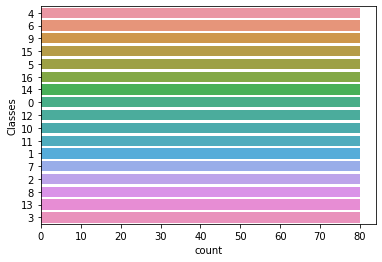

In [18]:
sns.countplot(y=df['Classes']);

In [19]:
df['Classes'].value_counts()

7     80
12    80
4     80
9     80
14    80
8     80
15    80
11    80
2     80
0     80
6     80
10    80
5     80
16    80
1     80
13    80
3     80
Name: Classes, dtype: int64

#### From above we can observe that classes are evenly distributed i.e each class have equal number of samples

### Analysing dimensions of random image

Label: 4
Shape : (500, 666, 3)


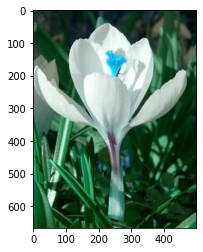

In [94]:
example_file =df.loc[5]['Images']
print("Label:",df.loc[5]['Classes'])
img = cv2.imread(example_file,1)
print("Shape :",im.shape)
plt.imshow(img)
plt.show();

#### Blur Filter

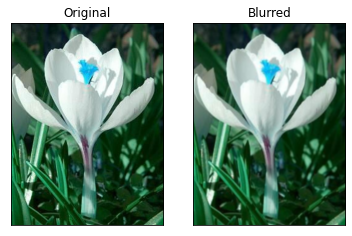

In [96]:
im = img.copy()
blur = cv2.blur(im,(5,5))
plt.subplot(121),plt.imshow(im),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

#### Edge detection

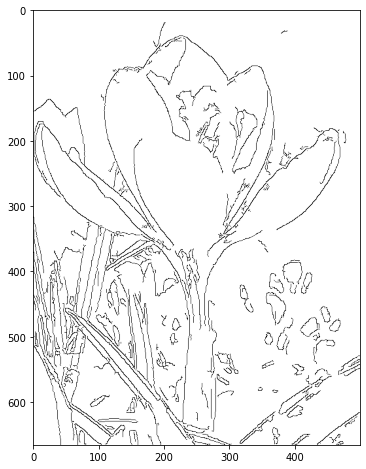

In [97]:
g = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
edge = cv2.Canny(g, 60, 180)
fig, ax = plt.subplots(1, figsize=(12,8))
plt.imshow(edge, cmap='Greys');

### Contour detection

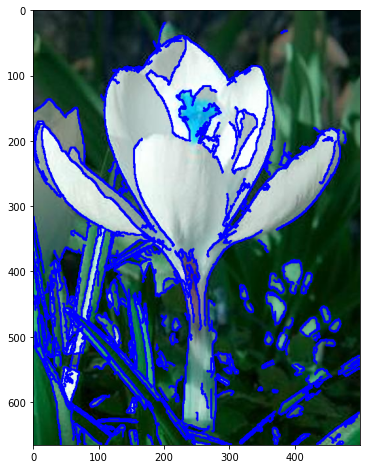

In [98]:
contours = cv2.findContours(edge, 
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_NONE)
cv2.drawContours(im, contours[0], -1, (0,0,255), thickness = 2)
fig, ax = plt.subplots(1, figsize=(12,8))
plt.imshow(im);

#### Embossing

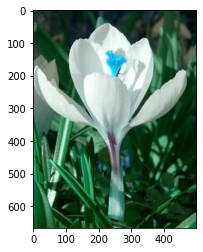

In [99]:
height, width = img.shape[:2]
y = np.ones((height, width), np.uint8) * 128
output = np.zeros((height, width), np.uint8)
kernel1 = np.array([[0, -1, -1], # kernel for embossing bottom left side
                    [1, 0, -1],
                    [1, 1, 0]])
kernel2 = np.array([[-1, -1, 0], # kernel for embossing bottom right side
                    [-1, 0, 1],
                    [0, 1, 1]])
output1 = cv2.add(cv2.filter2D(g, -1, kernel1), y) # emboss on bottom left side
output2 = cv2.add(cv2.filter2D(g, -1, kernel2), y) # emboss on bottom right side
for i in range(height):
    for j in range(width):
        output[i, j] = max(output1[i, j], output2[i, j])
plt.imshow(img);

Embossing bottom left side


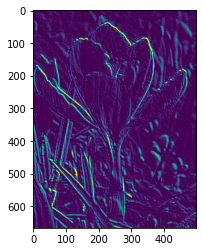

In [100]:
print("Embossing bottom left side")
plt.imshow(output1);

Embossing bottom right side


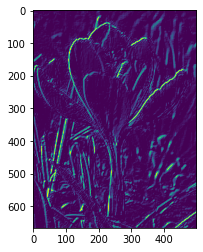

In [101]:
print("Embossing bottom right side")
plt.imshow(output2);

### Gaussian blurring

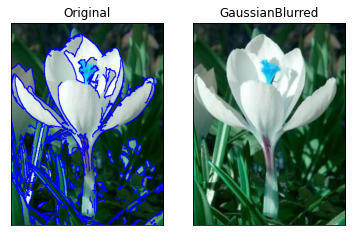

In [103]:
blur = cv2.GaussianBlur(img,(5,5),0)
plt.subplot(121),plt.imshow(im),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('GaussianBlurred')
plt.xticks([]), plt.yticks([])
plt.show()

Label: 4
Shape : (500, 625, 3)


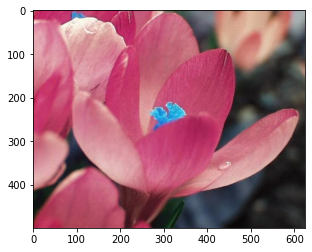

In [21]:
example_file =df.loc[78]['Images']
print("Label:",df.loc[78]['Classes'])
im = cv2.imread(example_file,1)
print("Shape :",im.shape)
plt.imshow(im)
plt.show();

#### We can see that we have images with different dimensions. Hence we need to resize it 

### Preprocessing the images

We will apply below mentioned preprocessing steps in order before feeding the data for training:<p>
<li>Resize all the images equally to 256*256*3 shape
<li>Normalize all the pixel values
<li>One hot encode all the target variables

### Resizing the elements

In [22]:
x_feat = []
y_feat = []
img_rows = 256
img_cols = 256
idx = 0
for i in tqdm(labels):
  abs_path = path+i
  files = os.listdir(abs_path)
  generator = (abs_path+'/'+file for file in files)
  for image in generator:
    img = cv2.imread(image,1) # 0 is to read image in grayscale mode
    img_resize = cv2.resize(img,(img_rows,img_cols))
    x_feat.append(img_resize)
    y_feat.append(i)

100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


### Pickling the list for future use

In [23]:
pickle_list(r"/content/17flowers/","part4xFeat.pkl",x_feat)

### Normalizing the pixel values and one hot encoding of the target value

In [25]:
X = np.array(x_feat,np.float32)/255
y = tensorflow.keras.utils.to_categorical(y_feat,num_classes=None, dtype='int')

In [26]:
X.shape

(1360, 256, 256, 3)

In [27]:
y.shape

(1360, 17)

### Train test split

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print (x_train.shape)
print (x_test.shape)

(1088, 256, 256, 3)
(272, 256, 256, 3)


In [29]:
def recall_c(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_c(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_c(y_true, y_pred)
    recall = recall_c(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [30]:
my_callbacks = [EarlyStopping(monitor='f1_score', patience=300, verbose=1, mode='max')]

### Training on normal CNN architecture

In [55]:
model = Sequential()
    
    #First Convolution and Pooling layer
model.add(Conv2D(96,(11,11),strides=(4,4),input_shape=(256,256,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    
    #Second Convolution and Pooling layer
model.add(Conv2D(256,(5,5),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    
    #Three Convolution layer and Pooling Layer
model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    
    #Fully connection layer
model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000,activation='relu'))
model.add(Dropout(0.5))
    
    #Classfication layer
model.add(Dense(17,activation='softmax'))

In [56]:
adam = tensorflow.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False,
    name='Adam')
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(lr=2e-4), metrics=['accuracy',f1_score])
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size = 20, 
                    validation_split=0.2,callbacks=my_callbacks)

Epoch 1/100
44/44 [==============================] - 6s 90ms/step - loss: 2.8897 - accuracy: 0.0476 - f1_score: 0.0000e+00 - val_loss: 2.8315 - val_accuracy: 0.0550 - val_f1_score: 0.0000e+00
Epoch 2/100
44/44 [==============================] - 3s 63ms/step - loss: 2.8132 - accuracy: 0.0904 - f1_score: 0.0022 - val_loss: 2.4994 - val_accuracy: 0.1193 - val_f1_score: 0.0000e+00
Epoch 3/100
44/44 [==============================] - 3s 63ms/step - loss: 2.5797 - accuracy: 0.1222 - f1_score: 0.0050 - val_loss: 2.4026 - val_accuracy: 0.1468 - val_f1_score: 0.0000e+00
Epoch 4/100
44/44 [==============================] - 3s 64ms/step - loss: 2.4052 - accuracy: 0.1691 - f1_score: 0.0236 - val_loss: 2.2257 - val_accuracy: 0.2339 - val_f1_score: 0.0694
Epoch 5/100
44/44 [==============================] - 3s 63ms/step - loss: 2.2480 - accuracy: 0.2171 - f1_score: 0.0732 - val_loss: 2.1518 - val_accuracy: 0.2110 - val_f1_score: 0.1486
Epoch 6/100
44/44 [==============================] - 3s 63ms/ste

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


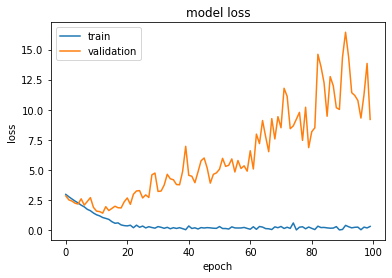

In [58]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [133]:
y_pred = model.predict_classes(x_test)
y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
print(classification_report(y_pred,y_classes))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


              precision    recall  f1-score   support

           0       0.41      0.39      0.40        18
           1       0.54      0.58      0.56        12
           2       0.83      0.94      0.88        16
           3       0.57      0.42      0.48        19
           4       0.62      0.59      0.61        17
           5       0.72      0.68      0.70        19
           6       0.69      0.50      0.58        18
           7       0.88      0.68      0.77        22
           8       0.90      0.82      0.86        11
           9       0.78      0.82      0.80        17
          10       0.79      0.79      0.79        19
          11       0.73      0.73      0.73        15
          12       0.82      0.90      0.86        10
          13       1.00      0.92      0.96        13
          14       0.23      0.38      0.29        13
          15       0.88      1.00      0.93        21
          16       0.80      1.00      0.89        12

    accuracy              

In [77]:
model.save("/content/17flowers/modelTrainedWithCNN.h5")

#### From above we found out that the weighted f1 score average is 68%. Let us try transfer learning and see if the score improves

### Using InceptionV3 architecture with transfer learning

In [46]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights = 'imagenet',include_top = False, pooling="avg",input_shape=(256,256,3),classes=17)

In [47]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 127, 127, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 127, 127, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 127, 127, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [48]:
for layer in base_model.layers:
   layer.trainable = False 

In [49]:
from keras import models,layers
import tensorflow
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17,activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 17)                17425     
Total params: 23,918,385
Trainable params: 2,115,601
Non-trainable params: 21,802,784
_________________________________________________________________


In [50]:
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(lr=2e-4), metrics=['accuracy',f1_score])
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size = 20, 
                    validation_split=0.2,callbacks=my_callbacks)

Epoch 1/30
44/44 [==============================] - 8s 104ms/step - loss: 2.4569 - accuracy: 0.2618 - f1_score: 0.0923 - val_loss: 1.3116 - val_accuracy: 0.5826 - val_f1_score: 0.3490
Epoch 2/30
44/44 [==============================] - 3s 77ms/step - loss: 1.1186 - accuracy: 0.6643 - f1_score: 0.5542 - val_loss: 0.8707 - val_accuracy: 0.7477 - val_f1_score: 0.6524
Epoch 3/30
44/44 [==============================] - 3s 77ms/step - loss: 0.7215 - accuracy: 0.7839 - f1_score: 0.7479 - val_loss: 0.7857 - val_accuracy: 0.7431 - val_f1_score: 0.7106
Epoch 4/30
44/44 [==============================] - 3s 77ms/step - loss: 0.5946 - accuracy: 0.8339 - f1_score: 0.7945 - val_loss: 0.7007 - val_accuracy: 0.7752 - val_f1_score: 0.7646
Epoch 5/30
44/44 [==============================] - 3s 77ms/step - loss: 0.4146 - accuracy: 0.8934 - f1_score: 0.8790 - val_loss: 0.6376 - val_accuracy: 0.7890 - val_f1_score: 0.7747
Epoch 6/30
44/44 [==============================] - 3s 77ms/step - loss: 0.3239 - ac

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


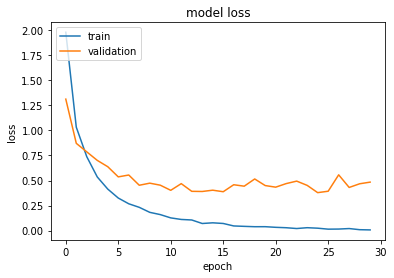

In [51]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


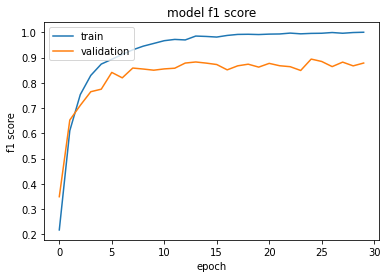

In [52]:
print(history.history.keys())
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [53]:
y_pred = model.predict_classes(x_test)
y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
print(classification_report(y_pred,y_classes))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.80      0.89      0.84        18
           1       1.00      0.93      0.96        14
           2       0.92      0.92      0.92        13
           3       1.00      0.64      0.78        28
           4       0.87      0.93      0.90        14
           5       1.00      1.00      1.00        14
           6       0.71      1.00      0.83        10
           7       0.72      0.78      0.75        23
           8       0.84      0.94      0.89        17
           9       0.92      0.80      0.86        15
          10       0.86      1.00      0.92        12
          11       0.75      0.94      0.83        16
          12       0.93      0.76      0.84        17
          13       1.00      0.69      0.81        16
          14       0.88      1.00      0.94        15
          15       0.94      1.00      0.97        15
          16       0.88      0.93      0.90        15

    accuracy              

In [54]:
model.save("/content/17flowers/model_trained_onInceptionV3.h5")

#### Our f1 score has improved to 0.87

### Training on VGG16(Transfer Learning)

In [31]:
from keras.applications.vgg16  import VGG16

base_model = VGG16(weights = 'imagenet',include_top = False, pooling="avg",input_shape=(256,256,3),classes=17)

In [32]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [33]:
for layer in base_model.layers:
   layer.trainable = False

In [34]:
from keras import models,layers
import tensorflow
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17,activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 17)                17425     
Total params: 15,257,425
Trainable params: 542,737
Non-trainable params: 14,714,688
_________________________________________________________________


In [35]:
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.RMSprop(lr=2e-4), metrics=['accuracy',f1_score])
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size = 20, 
                    validation_split=0.2,callbacks=my_callbacks)

Epoch 1/100
44/44 [==============================] - 28s 315ms/step - loss: 2.8807 - accuracy: 0.0805 - f1_score: 0.0000e+00 - val_loss: 2.6027 - val_accuracy: 0.2523 - val_f1_score: 0.0000e+00
Epoch 2/100
44/44 [==============================] - 7s 157ms/step - loss: 2.5448 - accuracy: 0.2496 - f1_score: 0.0000e+00 - val_loss: 2.3999 - val_accuracy: 0.3578 - val_f1_score: 0.0000e+00
Epoch 3/100
44/44 [==============================] - 7s 159ms/step - loss: 2.3405 - accuracy: 0.3316 - f1_score: 0.0014 - val_loss: 2.2069 - val_accuracy: 0.5000 - val_f1_score: 0.0000e+00
Epoch 4/100
44/44 [==============================] - 7s 159ms/step - loss: 2.1204 - accuracy: 0.4000 - f1_score: 0.0215 - val_loss: 2.0469 - val_accuracy: 0.5780 - val_f1_score: 0.0087
Epoch 5/100
44/44 [==============================] - 7s 160ms/step - loss: 1.9186 - accuracy: 0.5305 - f1_score: 0.0514 - val_loss: 1.9242 - val_accuracy: 0.5275 - val_f1_score: 0.0598
Epoch 6/100
44/44 [==============================] - 7

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


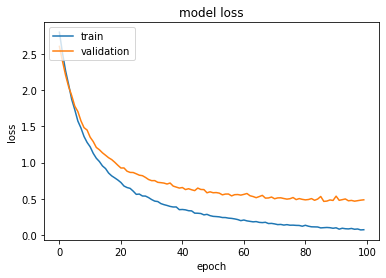

In [36]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


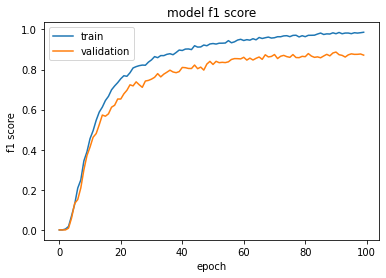

In [37]:
print(history.history.keys())
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [38]:
y_pred = model.predict_classes(x_test)
y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]
print(classification_report(y_pred,y_classes))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       1.00      0.72      0.84        18
           2       1.00      1.00      1.00        13
           3       1.00      0.95      0.97        19
           4       0.87      0.81      0.84        16
           5       1.00      1.00      1.00        14
           6       0.93      1.00      0.96        13
           7       0.84      0.81      0.82        26
           8       0.79      0.88      0.83        17
           9       1.00      1.00      1.00        13
          10       0.79      1.00      0.88        11
          11       0.80      0.94      0.86        17
          12       0.93      0.87      0.90        15
          13       1.00      0.65      0.79        17
          14       0.88      0.94      0.91        16
          15       0.88      1.00      0.93        14
          16       0.88      0.93      0.90        15

    accuracy              

#### With VGG16 transfer learning the f1 score improved drastically. We will save this application for our tkinter application

In [39]:
model.save("/content/17flowers/model_trained_onVGG16.h5")

<b>Observations:</b>
<li>We have got great results when we used transfer learning with InceptionV3 and VGG16.
<li>VGG16 model was more accurate but InceptionV3 model converged faster, so InceptionV3 architecture with imagenet weights is better